<a href="https://colab.research.google.com/github/SamuelVinay91/MachineLearning/blob/master/Mercedes_Benz_Problem_statement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mercedes-Benz Greener Manufacturing


Problem Statement Scenario:
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with a crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz is the leader in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, the company’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Mercedes-Benz’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Mercedes-Benz’s standards.

Following actions should be performed:

* If for any column(s), the variance is equal to zero, then you need to remove those variable(s).
* Check for null and unique values for test and train sets.
* Apply label encoder.
* Perform dimensionality reduction.
* Predict your test_df values using XGBoost.

# Import the required libraries

In [0]:
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# for dimensionality reduction
from sklearn.decomposition import PCA,FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns

import matplotlib.pyplot as plt

import time

# Read the data from train.csv

In [51]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# let us understand the data
print('Size of training set: {} rows and {} columns'
      .format(*df_train.shape))
# print few rows and see how the data looks like
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#Collect the Y values into an array

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


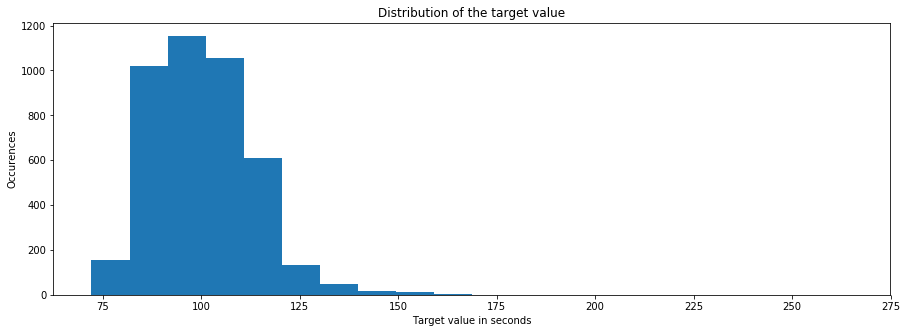

In [52]:
# seperate the y from the data as we will use this to learn as 
# the prediction output
y_train = df_train['y'].values

plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

#Understand the data types we have (Feature Analysis)

In [0]:
# iterate through all the columns which has X in the name of the column
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

#Count the data in each of the columns


In [0]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1:
        counts[0].append(c)
    elif uniq == 2 and typ == np.int64:
        counts[1].append(c)
    else:
        counts[2].append(c)

print('Constant features: {} Binary features: {} Categorical features: {}\n'
      .format(*[len(c) for c in counts]))
print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


#Outlier detection and removal and cleaning

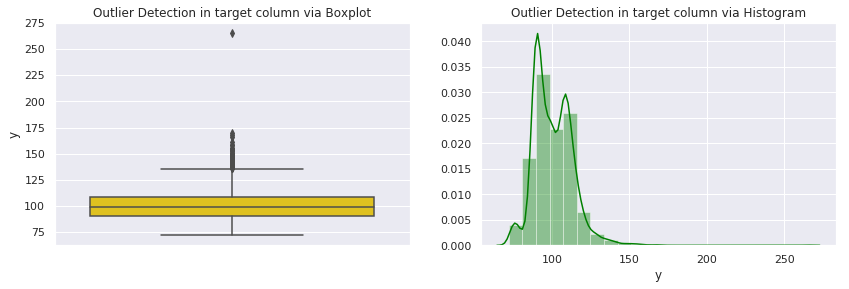

In [54]:
sns.set(rc={'figure.figsize':(14,9)})
plt.subplot(221)
plt.title("Outlier Detection in target column via Boxplot")
plt.ylabel("Values of y")
plt.grid(True)
sns.boxplot(y=df_train["y"],color='gold')
plt.subplot(222)
plt.title("Outlier Detection in target column via Histogram")
plt.grid(True)
ax = sns.distplot(df_train.y,color='green',bins=22)
plt.show()

This clearly shows the outliers are above a value of approx. 137.5. Well we will remove outliers after 150.

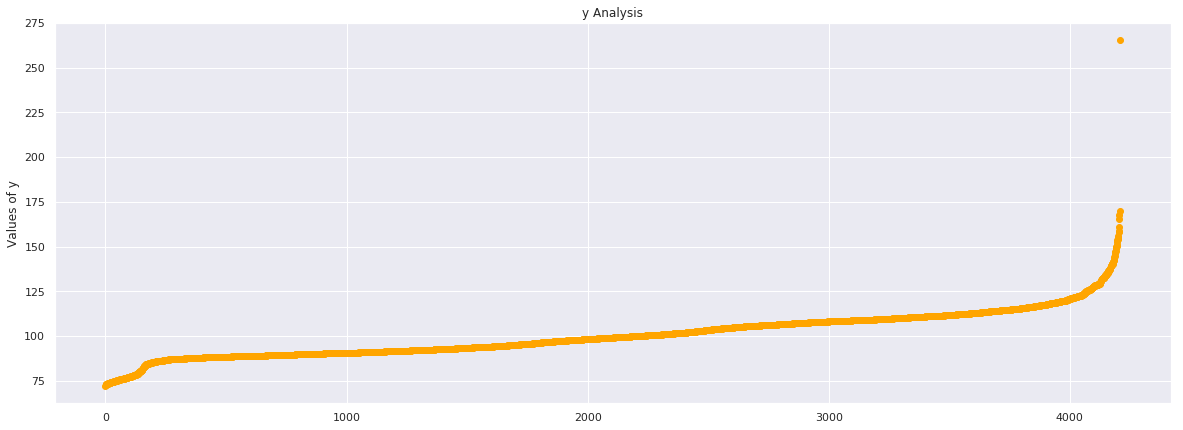

In [55]:
sns.set(rc={'figure.figsize':(20,7)})
plt.title("y Analysis")
plt.ylabel("Values of y")
plt.scatter(range(df_train.shape[0]),np.sort(df_train.y.values),color='orange')

A very distinct and conspicuous point around 275 in boxplot and also the green area in histogram. This noise has to removed.

# Trend y vs ID 

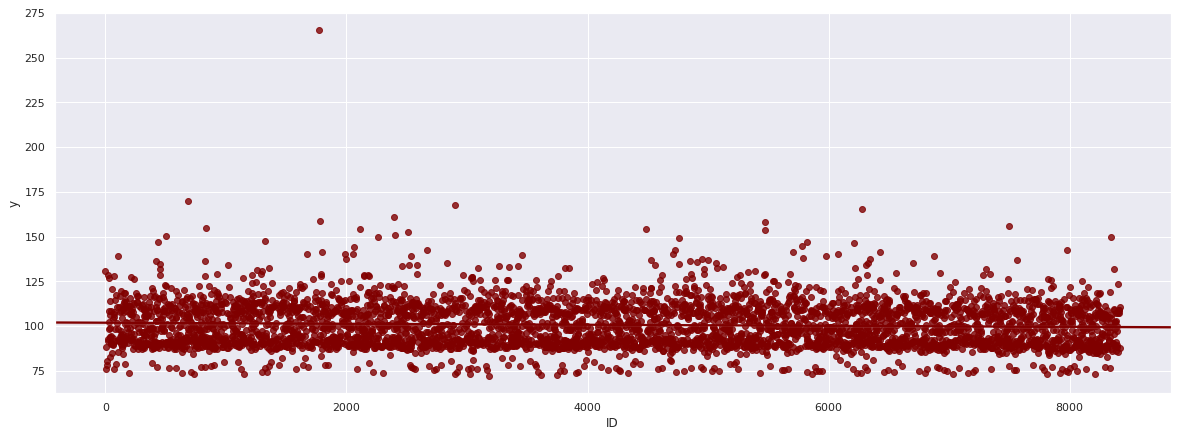

In [57]:
sns.set(rc={'figure.figsize':(20,7)})
sns.regplot(x='ID', y='y', data=df_train,color='maroon')

This shows a very slight decreasing trend of y wrt ID , maybe cars later in series took less time in test bench. This gives ID an importance while estimating y.

##If for any column(s), the variance is equal to zero, then remove those variable(s). As analysed earlier (y vs ID)

In [56]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train[usable_columns]
x_test = df_test[usable_columns]

# shape        
print('Shape train: {}'.format(x_train.shape))

Shape train: (4209, 376)


#Apply label encoder

In [0]:
# process columns, apply LabelEncoder to categorical features
for c in usable_columns:
    if x_train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(x_train[c].values) + list(x_test[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        x_test[c] = lbl.transform(list(x_test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

x_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Shape train: (4209, 376)
Shape test: (4209, 376)


,X283,X154,X356,X44,X380,X104,X148,X110,X22,X245,X42,X246,X57,X272,X323,X232,X308,X368,X287,X29,X38,X316,X17,X64,X338,X218,X173,X240,X289,X273,X79,X10,X180,X67,X190,X322,X140,X361,X375,X383,...,X170,X334,X346,X69,X147,X137,X371,X315,X260,X295,X93,X150,X15,X234,X326,X45,X32,X261,X265,X134,X185,X99,X379,X311,X84,X352,X127,X4,X215,X271,X228,X266,X167,X354,X196,X276,X370,X33,X171,X58
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,1,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
# Commented as per the review comments and implemented LabelEncoder
# for column in usable_columns:
#     cardinality = len(np.unique(x_train[column]))
#     if cardinality == 1:
#         x_train.drop(column, axis=1) # Column with only one 
#         # value is useless so we drop it
#         x_test.drop(column, axis=1)
#     if cardinality > 2: # Column is categorical
#         mapper = lambda x: sum([ord(digit) for digit in x])
#         x_train[column] = x_train[column].apply(mapper)
#         x_test[column] = x_test[column].apply(mapper)
# x_train.head()

#Check for null and unique values for test and train sets

In [0]:
def check_missing_values(df):
    if df.isnull().any().any():
        print("There are missing values in the dataframe")
    else:
        print("There are no missing values in the dataframe")
check_missing_values(x_train)
check_missing_values(x_test)

There are no missing values in the dataframe
There are no missing values in the dataframe


#Make sure the data is now changed into numericals

In [0]:
print('Feature types:')
x_train[cols].dtypes.value_counts()

Feature types:


int64    376
dtype: int64

#Perform dimensionality reduction

In [0]:
n_comp = 12
# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(x_train)
pca2_results_test = pca.transform(x_test)

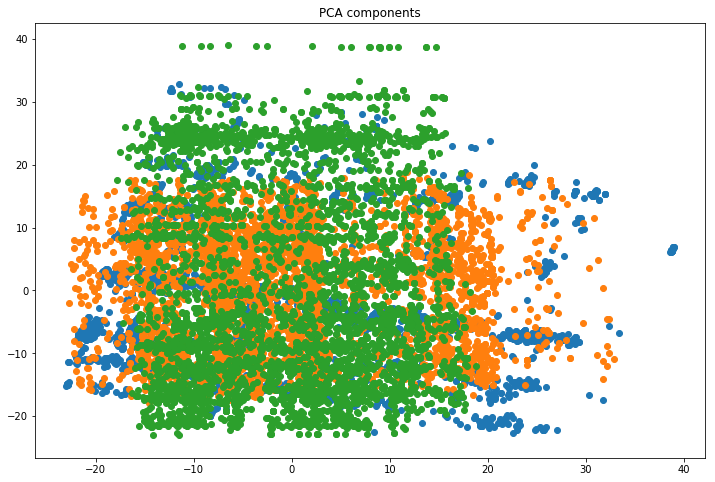

In [0]:
plt.figure(figsize=(12,8))
plt.title('PCA components')
plt.scatter(pca2_results_train[:,0], pca2_results_train[:,1])
plt.scatter(pca2_results_train[:,1], pca2_results_train[:,2])
plt.scatter(pca2_results_train[:,2], pca2_results_train[:,0])

In [0]:
# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(x_train)
ica2_results_test = ica.transform(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


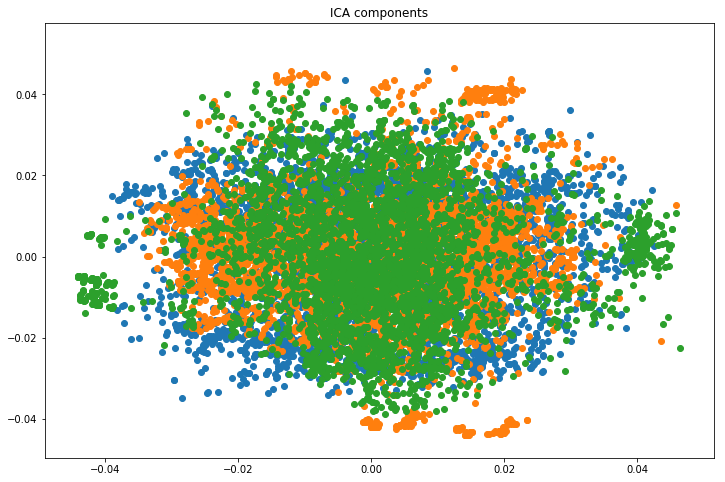

In [0]:
plt.figure(figsize=(12,8))
plt.title('ICA components')
plt.scatter(ica2_results_train[:,0], ica2_results_train[:,1])
plt.scatter(ica2_results_train[:,1], ica2_results_train[:,2])
plt.scatter(ica2_results_train[:,2], ica2_results_train[:,0])

# Training using xgboost

In [0]:
#PCA
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
        pca2_results_train, 
        y_train, test_size=0.2, 
        random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
#d_test = xgb.DMatrix(x_test)
d_test = xgb.DMatrix(pca2_results_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4
params['n_trees']= 100
params['subsample']=0.95
params['eval_metric']='rmse'


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 
                1000, watchlist, early_stopping_rounds=50, 
                feval=xgb_r2_score, maximize=True, verbose_eval=10)

[14:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:99.1509	valid-rmse:98.2674	train-r2:-58.3561	valid-r2:-67.6437
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.2775	valid-rmse:80.3512	train-r2:-38.8852	valid-r2:-44.8952
[20]	train-rmse:66.7114	valid-rmse:65.7447	train-r2:-25.8703	valid-r2:-29.7258
[30]	train-rmse:54.8584	valid-rmse:53.843	train-r2:-17.1701	valid-r2:-19.6082
[40]	train-rmse:45.2326	valid-rmse:44.1698	train-r2:-11.3531	valid-r2:-12.8686
[50]	train-rmse:37.4344	valid-rmse:36.3188	train-r2:-7.46082	valid-r2:-8.37659
[60]	train-rmse:31.1492	valid-rmse:29.9847	train-r2:-4.85822	valid-r2:-5.39121
[70]	train-rmse:26.0961	valid-rmse:24.8753	train-r2:-3.1117	valid-r2:-3.39866
[80]	train-rmse:22.0671	valid-rmse:20.7867	train-r2:-1.94009	valid-r2:-2.07153
[90]	train-rmse:18.8789	

In [0]:
# ICA
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
        ica2_results_train, 
        y_train, test_size=0.2, 
        random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
#d_test = xgb.DMatrix(x_test)
d_test = xgb.DMatrix(pca2_results_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4
params['n_trees']= 100
params['subsample']=0.95
params['eval_metric']='rmse'


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 
                1000, watchlist, early_stopping_rounds=50, 
                feval=xgb_r2_score, maximize=True, verbose_eval=10)

[13:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:98.9739	valid-rmse:99.8593	train-r2:-57.3606	valid-r2:-62.9204
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.1511	valid-rmse:81.9763	train-r2:-38.2345	valid-r2:-42.0764
[20]	train-rmse:66.6244	valid-rmse:67.4007	train-r2:-25.4451	valid-r2:-28.1201
[30]	train-rmse:54.8057	valid-rmse:55.5424	train-r2:-16.895	valid-r2:-18.7748
[40]	train-rmse:45.2099	valid-rmse:45.9059	train-r2:-11.1771	valid-r2:-12.5083
[50]	train-rmse:37.4356	valid-rmse:38.0859	train-r2:-7.34928	valid-r2:-8.29804
[60]	train-rmse:31.1665	valid-rmse:31.7763	train-r2:-4.78702	valid-r2:-5.47245
[70]	train-rmse:26.1342	valid-rmse:26.69	train-r2:-3.0691	valid-r2:-3.56624
[80]	train-rmse:22.1222	valid-rmse:22.6242	train-r2:-1.91566	valid-r2:-2.28104
[90]	train-rmse:18.95	vali